In [ ]:
# See if we can't refactor these functions into one pre-processing function. 
# Compile into pipeline
# Add the feature of getting rid of names
# Work on creating more columns (see doc for list of columns to make)
# Columns: Sentences, noun phrases, keywords, etc.
# Preprocess pipeline includes -- sentence tokens, word tokens, remove meaningless symbols and stopwords
# make all letters lowercase

In [1]:
import bs4

from collections import Counter

import matplotlib.pyplot as plt

import networkx as nx

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import numpy as np

# For reading files
import os

# Data manipulation
import pandas as pd

# Sentence boundary detection
import pysbd

from rake_nltk import Rake

import random

# Text cleaning
import re

import requests

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

## Text processing
# NLP
import spacy
from spacy.lang.en import English
from spacy.matcher import Matcher
from spacy.tokens import Span
nlp = spacy.load("en_core_web_sm")
from pysbd.utils import PySBDFactory


# More NLP for fun
from textblob import TextBlob

import texthero as hero

from tqdm import tqdm

# Pipeline creation
from sklearn.pipeline import Pipeline

# Text extraction
from tika import parser

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sambe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
# Wanted to see details
pd.options.display.max_rows = 999

### Breakdown sentences

<!--  Insert list of sentences into each cell  -->

In [12]:
df = pd.read_csv(r"C:\Users\sambe\Projects\Cover_Letter_Analysis\data\raw_data.csv", index_col=0)

In [3]:
df.head()

,username,title,raw_cover_letters,raw_resume
0,Aakash Patel,Media Planner,"I was excited to discover the Media Planner position with Rookieplay, which I saw posted on Indeed. Rookieplay is a company on the rise, and as a recent college graduate with 2 years of diverse ma...","Microsoft Word - Aakash Patel 1\tAakash Patel aakashp047@gmail.com v (516) 404-6119 v Syosset, NY EDUCATION Stony Brook University ..."
1,Aaron Neal,Media Planner,"Dear Hiring Manager,I am writing to you today to apply for the open position of Media Planner. As a marketing professional with 2+ years of experience I believe that I will be an asset to the Rook...","_Aaron Neal_052020_v2A A R O N M . N E A LSTRATEGISTPERSONALTRAITS & SKILLSEDUCATIONCONTACT770.871.5294aaronm.neal3@gmail.comProficient in Simmons OneView, Global Web Index MS Office Perspective..."
2,Aaron Penzel,Media Planner,"Dear Hiring Manager,I am writing to express interest in Rookieplay’s Media Planner position. I am a creative and out-of-the-box marketer in the entertainment industry, with experience in both non-...","AARON PENZELAARON PENZELENTERTAINMENT ADVERTISERCONTACTPHONE: (908) 217-7289 EMAIL: A.PENZEL724@GMAIL.COM 23-43 28TH STREET LONG ISLAND CITY, NY 11105 WORK EXPERIENCEManaged all traditional media..."
3,Abby Cleary,Media Planner,NaN,"Abby ClearyBuffalo, NYabbycleary7_pb3@indeedemail.com(716) 238-0440Authorized to work in the US for any employerWork ExperienceInternSwanson Communications - New York, NYJune 2019 to Present• Ass..."
4,Abdul Albab,Accounts Payable Specialist,NaN,"Abdul AlbabBronx, NY 10467abdulalbab2_n6u@indeedemail.com(347) 615-8170Work ExperienceAccountantCS Corporation - Bronx, NYJune 2017 to Present• Manage and oversee daily Accounts Payable and Accou..."


In [90]:
df_cover_letters = df[['username', 'raw_cover_letters']]

In [91]:
df_resumes = df[['username', 'raw_resume']]

In [92]:
df_cover_letters = df_cover_letters.dropna()

In [93]:
df_resumes = df_resumes.dropna()

In [94]:
df_cover_letters = df_cover_letters.rename(columns={'raw_cover_letters': 'raw_text'})

In [95]:
df_resumes = df_resumes.rename(columns={'raw_resume': 'raw_text'})

In [96]:
df = df_resumes.append(df_cover_letters)

In [101]:
len(df)

3581

In [102]:
len(sentences)

0

In [98]:
df = df.reset_index(drop=True)

In [63]:
df.raw_text[0]

"Microsoft Word - Aakash Patel  1\tAakash Patel aakashp047@gmail.com v (516) 404-6119 v Syosset, NY  EDUCATION    Stony Brook University                                                                     December 2019 Bachelor of Science in Business Management, GPA 3.45/4.0                    Stony Brook, NY § Member of the American Marketing Association, Economics Club, and South Asian Student Alliance § Studied abroad in Madrid, Spain during the Spring 2019 semester (Universidad Carlos III de Madrid)  WORK EXPERIENCE   Keller Williams Realty                              May 2018 – Aug. 2018 Marketing Intern                             New York, NY § Member of the renowned luxury real estate practice of the Nicole Gary Team, one of the highest grossing Keller Williams teams worldwide. § Honed speaking skills by interacting with clients and maintaining a CRM database (Base). § Perfected the use of Wix in order to make improvements to the team website used to attract new clients. § Uti

In [109]:
sentence = []
for text in df.raw_text[:3]:
    doc = nlp(text)   
    extracted_sentence = list(doc.sents)  
    sentence.append(extracted_sentence)

In [110]:
sentence

[[Microsoft Word - Aakash Patel  1	,
  Aakash Patel,
  aakashp047@gmail.com v (516),
  404-6119 v Syosset, NY  EDUCATION    Stony Brook University                                                                     December 2019 Bachelor of Science in Business Management, GPA 3.45/4.0                    Stony Brook, NY § Member of the American Marketing Association, Economics Club, and South Asian Student Alliance § Studied abroad in Madrid, Spain during the Spring 2019 semester (Universidad Carlos III de Madrid)  ,
  WORK EXPERIENCE   ,
  Keller Williams Realty                              ,
  May 2018 – Aug. 2018,
  Marketing Intern                             ,
  New York, NY § Member of the renowned luxury real estate practice of the Nicole Gary Team, one of the highest grossing Keller Williams teams worldwide.,
  §,
  Honed speaking skills by interacting with clients and maintaining a CRM database (Base).,
  § Perfected the use of Wix in order to make improvements to the team webs

In [116]:
# Breakdown documents into sentences with pysbd and spacy
# It seems like with this example, spacy is the better option for parsing sentences
sentences = []
def extract_sentences():
    for text in df.raw_text:
        doc = nlp(text)
        extracted_sentences = list(doc.sents)
        if extracted_sentences == None:
            print(df_resumes['username'] + ' is bad.')
        sentences.append(extracted_sentences)

extract_sentences()


In [115]:
sentences

[[Microsoft Word - Aakash Patel  1	,
  Aakash Patel,
  aakashp047@gmail.com v (516),
  404-6119 v Syosset, NY  EDUCATION    Stony Brook University                                                                     December 2019 Bachelor of Science in Business Management, GPA 3.45/4.0                    Stony Brook, NY § Member of the American Marketing Association, Economics Club, and South Asian Student Alliance § Studied abroad in Madrid, Spain during the Spring 2019 semester (Universidad Carlos III de Madrid)  ,
  WORK EXPERIENCE   ,
  Keller Williams Realty                              ,
  May 2018 – Aug. 2018,
  Marketing Intern                             ,
  New York, NY § Member of the renowned luxury real estate practice of the Nicole Gary Team, one of the highest grossing Keller Williams teams worldwide.,
  §,
  Honed speaking skills by interacting with clients and maintaining a CRM database (Base).,
  § Perfected the use of Wix in order to make improvements to the team webs

In [117]:
df['sentences'] = sentences

In [118]:
df.to_csv('data/tokens_df.csv')

In [6]:
tokens_df = pd.read_csv('data/tokens_df.csv', index_col=0)

In [7]:
tokens_df.head()

,username,raw_text,sentences
0,Aakash Patel,"Microsoft Word - Aakash Patel 1\tAakash Patel aakashp047@gmail.com v (516) 404-6119 v Syosset, NY EDUCATION Stony Brook University ...","[Microsoft Word - Aakash Patel 1\t, Aakash Patel, aakashp047@gmail.com v (516), 404-6119 v Syosset, NY EDUCATION Stony Brook University ..."
1,Aaron Neal,"_Aaron Neal_052020_v2A A R O N M . N E A LSTRATEGISTPERSONALTRAITS & SKILLSEDUCATIONCONTACT770.871.5294aaronm.neal3@gmail.comProficient in Simmons OneView, Global Web Index MS Office Perspective...","[_, Aaron Neal_052020_v2A A R O N M . , N, E A LSTRATEGISTPERSONALTRAITS & SKILLSEDUCATIONCONTACT770.871.5294aaronm.neal3@gmail.comProficient in Simmons OneView, Global Web Index MS Office Persp..."
2,Aaron Penzel,"AARON PENZELAARON PENZELENTERTAINMENT ADVERTISERCONTACTPHONE: (908) 217-7289 EMAIL: A.PENZEL724@GMAIL.COM 23-43 28TH STREET LONG ISLAND CITY, NY 11105 WORK EXPERIENCEManaged all traditional media...","[AARON PENZELAARON PENZELENTERTAINMENT ADVERTISERCONTACTPHONE:, (908) 217-7289 EMAIL: A.PENZEL724@GMAIL.COM 23-43 28TH STREET LONG ISLAND CITY, NY 11105, WORK EXPERIENCEManaged, all traditional m..."
3,Abby Cleary,"Abby ClearyBuffalo, NYabbycleary7_pb3@indeedemail.com(716) 238-0440Authorized to work in the US for any employerWork ExperienceInternSwanson Communications - New York, NYJune 2019 to Present• Ass...","[ Abby ClearyBuffalo, NYabbycleary7_pb3@indeedemail.com(716), 238-0440Authorized to work in the US for any employerWork ExperienceInternSwanson Communications - New York, NYJune 2019 to Present• A..."
4,Abdul Albab,"Abdul AlbabBronx, NY 10467abdulalbab2_n6u@indeedemail.com(347) 615-8170Work ExperienceAccountantCS Corporation - Bronx, NYJune 2017 to Present• Manage and oversee daily Accounts Payable and Accou...","[ Abdul AlbabBronx, NY 10467abdulalbab2_n6u@indeedemail.com(347), 615-8170Work, ExperienceAccountantCS Corporation - Bronx, NYJune 2017 to Present• Manage and oversee daily Accounts Payable and Ac..."


In [8]:
len(tokens_df)

3581

In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)
    text = re.sub(BAD_SYMBOLS_RE, '', text)
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])

    return text

In [16]:
tokens_df['clean_text'] = clean_text

In [18]:
tokens = [x.split() for x in tokens_df.clean_text]

In [20]:
tokens_df['tokens'] = tokens

In [23]:
tokens_df

,username,raw_text,sentences,clean_text,tokens
0,Aakash Patel,"Microsoft Word - Aakash Patel 1\tAakash Patel aakashp047@gmail.com v (516) 404-6119 v Syosset, NY EDUCATION Stony Brook University ...","[Microsoft Word - Aakash Patel 1\t, Aakash Patel, aakashp047@gmail.com v (516), 404-6119 v Syosset, NY EDUCATION Stony Brook University ...",microsoft word aakash patel 1aakash patel aakashp047 gmailcom v 516 4046119 v syosset ny education stony brook university december 2019 bachelor science business management gpa 345 40 stony brook ...,"[microsoft, word, aakash, patel, 1aakash, patel, aakashp047, gmailcom, v, 516, 4046119, v, syosset, ny, education, stony, brook, university, december, 2019, bachelor, science, business, management..."
1,Aaron Neal,"_Aaron Neal_052020_v2A A R O N M . N E A LSTRATEGISTPERSONALTRAITS & SKILLSEDUCATIONCONTACT770.871.5294aaronm.neal3@gmail.comProficient in Simmons OneView, Global Web Index MS Office Perspective...","[_, Aaron Neal_052020_v2A A R O N M . , N, E A LSTRATEGISTPERSONALTRAITS & SKILLSEDUCATIONCONTACT770.871.5294aaronm.neal3@gmail.comProficient in Simmons OneView, Global Web Index MS Office Persp...",_aaron neal_052020_v2a r n n e lstrategistpersonaltraits skillseducationcontact7708715294aaronmneal3 gmailcomproficient simmons oneview global web index ms office perspective seeker passionate und...,"[_aaron, neal_052020_v2a, r, n, n, e, lstrategistpersonaltraits, skillseducationcontact7708715294aaronmneal3, gmailcomproficient, simmons, oneview, global, web, index, ms, office, perspective, see..."
2,Aaron Penzel,"AARON PENZELAARON PENZELENTERTAINMENT ADVERTISERCONTACTPHONE: (908) 217-7289 EMAIL: A.PENZEL724@GMAIL.COM 23-43 28TH STREET LONG ISLAND CITY, NY 11105 WORK EXPERIENCEManaged all traditional media...","[AARON PENZELAARON PENZELENTERTAINMENT ADVERTISERCONTACTPHONE:, (908) 217-7289 EMAIL: A.PENZEL724@GMAIL.COM 23-43 28TH STREET LONG ISLAND CITY, NY 11105, WORK EXPERIENCEManaged, all traditional m...",aaron penzelaaron penzelentertainment advertisercontactphone 908 2177289 email apenzel724 gmailcom 2343 28th street long island city ny 11105 work experiencemanaged traditional media advertising 1...,"[aaron, penzelaaron, penzelentertainment, advertisercontactphone, 908, 2177289, email, apenzel724, gmailcom, 2343, 28th, street, long, island, city, ny, 11105, work, experiencemanaged, traditional..."
3,Abby Cleary,"Abby ClearyBuffalo, NYabbycleary7_pb3@indeedemail.com(716) 238-0440Authorized to work in the US for any employerWork ExperienceInternSwanson Communications - New York, NYJune 2019 to Present• Ass...","[ Abby ClearyBuffalo, NYabbycleary7_pb3@indeedemail.com(716), 238-0440Authorized to work in the US for any employerWork ExperienceInternSwanson Communications - New York, NYJune 2019 to Present• A...",abby clearybuffalo nyabbycleary7_pb3 indeedemailcom 716 2380440authorized work us employerwork experienceinternswanson communications new york nyjune 2019 present assisted tasks adhere strategic p...,"[abby, clearybuffalo, nyabbycleary7_pb3, indeedemailcom, 716, 2380440authorized, work, us, employerwork, experienceinternswanson, communications, new, york, nyjune, 2019, present, assisted, tasks,..."
4,Abdul Albab,"Abdul AlbabBronx, NY 10467abdulalbab2_n6u@indeedemail.com(347) 615-8170Work ExperienceAccountantCS Corporation - Bronx, NYJune 2017 to Present• Manage and oversee daily Accounts Payable and Accou...","[ Abdul AlbabBronx, NY 10467abdulalbab2_n6u@indeedemail.com(347), 615-8170Work, ExperienceAccountantCS Corporation - Bronx, NYJune 2017 to Present• Manage and oversee daily Accounts Payable and Ac...",abdul albabbronx ny 10467abdulalbab2_n6u indeedemailcom 347 6158170work experienceaccountantcs corporation bronx nyjune 2017 present manage oversee daily accounts payable accounts receivable proce...,"[abdul, albabbronx, ny, 10467abdulalbab2_n6u, indeedemailcom, 347, 6158170work, experienceaccountantcs, corporation, bronx, nyjune, 2017, present, manage, oversee, daily, accounts, payab

In [103]:
tokens_df.to_csv('tokens_df.csv')

In [ ]:
## Find keywords of each text in row

In [79]:
text = tokens_df['raw_text'][0]

In [80]:
text

"Microsoft Word - Aakash Patel  1\tAakash Patel aakashp047@gmail.com v (516) 404-6119 v Syosset, NY  EDUCATION    Stony Brook University                                                                     December 2019 Bachelor of Science in Business Management, GPA 3.45/4.0                    Stony Brook, NY § Member of the American Marketing Association, Economics Club, and South Asian Student Alliance § Studied abroad in Madrid, Spain during the Spring 2019 semester (Universidad Carlos III de Madrid)  WORK EXPERIENCE   Keller Williams Realty                              May 2018 – Aug. 2018 Marketing Intern                             New York, NY § Member of the renowned luxury real estate practice of the Nicole Gary Team, one of the highest grossing Keller Williams teams worldwide. § Honed speaking skills by interacting with clients and maintaining a CRM database (Base). § Perfected the use of Wix in order to make improvements to the team website used to attract new clients. § Uti

In [92]:
tokens_df

,username,raw_text,sentences,clean_text,tokens,key_words,key_phrases
0,Aakash Patel,"Microsoft Word - Aakash Patel 1\tAakash Patel aakashp047@gmail.com v (516) 404-6119 v Syosset, NY EDUCATION Stony Brook University ...","[Microsoft Word - Aakash Patel 1\t, Aakash Patel, aakashp047@gmail.com v (516), 404-6119 v Syosset, NY EDUCATION Stony Brook University ...",microsoft word aakash patel 1aakash patel aakashp047 gmailcom v 516 4046119 v syosset ny education stony brook university december 2019 bachelor science business management gpa 345 40 stony brook ...,"[microsoft, word, aakash, patel, 1aakash, patel, aakashp047, gmailcom, v, 516, 4046119, v, syosset, ny, education, stony, brook, university, december, 2019, bachelor, science, business, management...",,
1,Aaron Neal,"_Aaron Neal_052020_v2A A R O N M . N E A LSTRATEGISTPERSONALTRAITS & SKILLSEDUCATIONCONTACT770.871.5294aaronm.neal3@gmail.comProficient in Simmons OneView, Global Web Index MS Office Perspective...","[_, Aaron Neal_052020_v2A A R O N M . , N, E A LSTRATEGISTPERSONALTRAITS & SKILLSEDUCATIONCONTACT770.871.5294aaronm.neal3@gmail.comProficient in Simmons OneView, Global Web Index MS Office Persp...",_aaron neal_052020_v2a r n n e lstrategistpersonaltraits skillseducationcontact7708715294aaronmneal3 gmailcomproficient simmons oneview global web index ms office perspective seeker passionate und...,"[_aaron, neal_052020_v2a, r, n, n, e, lstrategistpersonaltraits, skillseducationcontact7708715294aaronmneal3, gmailcomproficient, simmons, oneview, global, web, index, ms, office, perspective, see...",,
2,Aaron Penzel,"AARON PENZELAARON PENZELENTERTAINMENT ADVERTISERCONTACTPHONE: (908) 217-7289 EMAIL: A.PENZEL724@GMAIL.COM 23-43 28TH STREET LONG ISLAND CITY, NY 11105 WORK EXPERIENCEManaged all traditional media...","[AARON PENZELAARON PENZELENTERTAINMENT ADVERTISERCONTACTPHONE:, (908) 217-7289 EMAIL: A.PENZEL724@GMAIL.COM 23-43 28TH STREET LONG ISLAND CITY, NY 11105, WORK EXPERIENCEManaged, all traditional m...",aaron penzelaaron penzelentertainment advertisercontactphone 908 2177289 email apenzel724 gmailcom 2343 28th street long island city ny 11105 work experiencemanaged traditional media advertising 1...,"[aaron, penzelaaron, penzelentertainment, advertisercontactphone, 908, 2177289, email, apenzel724, gmailcom, 2343, 28th, street, long, island, city, ny, 11105, work, experiencemanaged, traditional...",,
3,Abby Cleary,"Abby ClearyBuffalo, NYabbycleary7_pb3@indeedemail.com(716) 238-0440Authorized to work in the US for any employerWork ExperienceInternSwanson Communications - New York, NYJune 2019 to Present• Ass...","[ Abby ClearyBuffalo, NYabbycleary7_pb3@indeedemail.com(716), 238-0440Authorized to work in the US for any employerWork ExperienceInternSwanson Communications - New York, NYJune 2019 to Present• A...",abby clearybuffalo nyabbycleary7_pb3 indeedemailcom 716 2380440authorized work us employerwork experienceinternswanson communications new york nyjune 2019 present assisted tasks adhere strategic p...,"[abby, clearybuffalo, nyabbycleary7_pb3, indeedemailcom, 716, 2380440authorized, work, us, employerwork, experienceinternswanson, communications, new, york, nyjune, 2019, present, assisted, tasks,...",,
4,Abdul Albab,"Abdul AlbabBronx, NY 10467abdulalbab2_n6u@indeedemail.com(347) 615-8170Work ExperienceAccountantCS Corporation - Bronx, NYJune 2017 to Present• Manage and oversee daily Accounts Payable and Accou...","[ Abdul AlbabBronx, NY 10467abdulalbab2_n6u@indeedemail.com(347), 615-8170Work, ExperienceAccountantCS Corporation - Bronx, NYJune 2017 to Present• Manage and oversee daily Accounts Payable and Ac...",abdul albabbronx ny 10467abdulalbab2_n6u indeedemailcom 347 6158170work experienceaccountantcs corporation bronx nyjune 2017 present manage oversee daily accounts payable accounts receivable proce...,"[abdul, albabbronx, ny, 10467abdulalbab2_n6u, indeedemailcom, 347, 6158170work, experienceaccountantcs, corporation, bronx, nyjune, 2017, present, manage, o

In [98]:
key_phrases = []
r = Rake(min_length=1, max_length=4)
for text in tokens_df['raw_text']:
    r.extract_keywords_from_text(text)
    phrases = r.get_ranked_phrases_with_scores()
    key_phrases.append(phrases)


In [99]:
tokens_df['rake_key_phrases_with_scores'] = key_phrases

In [100]:
tokens_df

,username,raw_text,sentences,clean_text,tokens,key_words,key_phrases,rake_key_phrases,rake_key_phrases_with_scores
0,Aakash Patel,"Microsoft Word - Aakash Patel 1\tAakash Patel aakashp047@gmail.com v (516) 404-6119 v Syosset, NY EDUCATION Stony Brook University ...","[Microsoft Word - Aakash Patel 1\t, Aakash Patel, aakashp047@gmail.com v (516), 404-6119 v Syosset, NY EDUCATION Stony Brook University ...",microsoft word aakash patel 1aakash patel aakashp047 gmailcom v 516 4046119 v syosset ny education stony brook university december 2019 bachelor science business management gpa 345 40 stony brook ...,"[microsoft, word, aakash, patel, 1aakash, patel, aakashp047, gmailcom, v, 516, 4046119, v, syosset, ny, education, stony, brook, university, december, 2019, bachelor, science, business, management...",,,"[developing innovative booths ideas, social media marketing efforts, § generated new ideas, § honed speaking skills, § kept camp ahead, ny § managed group, § conducted market research, ny § member...","[(16.0, developing innovative booths ideas), (15.0, social media marketing efforts), (13.942857142857143, § generated new ideas), (13.809523809523808, § honed speaking skills), (13.476190476190476..."
1,Aaron Neal,"_Aaron Neal_052020_v2A A R O N M . N E A LSTRATEGISTPERSONALTRAITS & SKILLSEDUCATIONCONTACT770.871.5294aaronm.neal3@gmail.comProficient in Simmons OneView, Global Web Index MS Office Perspective...","[_, Aaron Neal_052020_v2A A R O N M . , N, E A LSTRATEGISTPERSONALTRAITS & SKILLSEDUCATIONCONTACT770.871.5294aaronm.neal3@gmail.comProficient in Simmons OneView, Global Web Index MS Office Persp...",_aaron neal_052020_v2a r n n e lstrategistpersonaltraits skillseducationcontact7708715294aaronmneal3 gmailcomproficient simmons oneview global web index ms office perspective seeker passionate und...,"[_aaron, neal_052020_v2a, r, n, n, e, lstrategistpersonaltraits, skillseducationcontact7708715294aaronmneal3, gmailcomproficient, simmons, oneview, global, web, index, ms, office, perspective, see...",,,"[prepared weekly competitive reports, included 3 store managaers, effectively reach target audiences, controlling costs .- proficient, associates .- reviewed weekly, experience training retail ass...","[(16.0, prepared weekly competitive reports), (16.0, included 3 store managaers), (16.0, effectively reach target audiences), (16.0, controlling costs .- proficient), (16.0, associates .- reviewed..."
2,Aaron Penzel,"AARON PENZELAARON PENZELENTERTAINMENT ADVERTISERCONTACTPHONE: (908) 217-7289 EMAIL: A.PENZEL724@GMAIL.COM 23-43 28TH STREET LONG ISLAND CITY, NY 11105 WORK EXPERIENCEManaged all traditional media...","[AARON PENZELAARON PENZELENTERTAINMENT ADVERTISERCONTACTPHONE:, (908) 217-7289 EMAIL: A.PENZEL724@GMAIL.COM 23-43 28TH STREET LONG ISLAND CITY, NY 11105, WORK EXPERIENCEManaged, all traditional m...",aaron penzelaaron penzelentertainment advertisercontactphone 908 2177289 email apenzel724 gmailcom 2343 28th street long island city ny 11105 work experiencemanaged traditional media advertising 1...,"[aaron, penzelaaron, penzelentertainment, advertisercontactphone, 908, 2177289, email, apenzel724, gmailcom, 2343, 28th, street, long, island, city, ny, 11105, work, experiencemanaged, traditional...",,,"[plazaguest services retail representative, ny 11105 work experiencemanaged, contact educational institutions andindividuals, attending professional development programming, aaron penzelaaron penz...","[(16.0, plazaguest services retail representative), (16.0, ny 11105 work experiencemanaged), (16.0, contact educational institutions andindividuals), (16.0, attending professional development prog..."
3,Abby Cleary,"Abby ClearyBuffalo, NYabbycleary7_pb3@indeedemail.com(716) 238-0440Authorized to work in the US for any employerWork ExperienceInternSwanson Communications - New York, NYJune 2019 to Present• Ass...","[ Abby ClearyBuffalo, NYabbycleary7_pb3@indeedemail.com(716), 238-0440Authorized to work in the US for any employerWork E

In [102]:
tokens_df = tokens_df.drop(['key_words', 'key_phrases'], axis=1)

In [ ]:
## Find keywords of entire corpus - LOL

In [120]:
for text in tokens_df.raw_text[0:2]:
    all_text = ''.join(text)

In [122]:
all_text = ' '.join(tokens_df.raw_text)

In [124]:
key_phrases = []
r = Rake(min_length=1, max_length=1)
r.extract_keywords_from_text(all_text)
phrases = r.get_ranked_phrases_with_scores()
key_phrases.append(phrases)

In [125]:
key_phrases

[[(16.0, 'wania nawazwania nawaz wnnawaz'),
  (16.0, 'sonic stimulifloor managerbar louie'),
  (16.0, 'sheppard ritti fozdaraccounting professionaltroy'),
  (16.0, 'qurrkehe2zvfhwao mehmet fatih erdogan'),
  (16.0, 'pment manag ermolly whitemollycw92'),
  (16.0, 'hispano americana ecuadores infantiles'),
  (16.0, 'fimi ™, lifeware ™,'),
  (16.0,
   'f6c602b6c128e11a2d5fea0081e23aad shyrell roundtreeadministrative assistantlakeland'),
  (16.0,
   'f24d1417fefd6c18ea7c278d3e46fc43eed53dc074545cb7 lizeth lopezhr generalistcompton'),
  (16.0, 'effectivenessof howardwoodcontributing photographerthe hilltop'),
  (16.0, 'ebuy tylar brownaccount executivechicago'),
  (16.0,
   'c8456f15d5f87c5a03d2610ea8dcb84deed53dc074545cb7 therese sherlaine emmonsbloomington'),
  (16.0,
   'af9e40eae4c387d705aa4857a5c1d0f5eed53dc074545cb7 odaly perezassistant controllermiami'),
  (16.0, 'adpstaff accountantcentral midlands rta'),
  (16.0, 'acha lynnette priceadministrative professionalhomosassa'),
  (16.0, 

In [ ]:
## Find keywords of all job descriptions - LOL

In [170]:
job_descriptions_df = pd.read_csv('data/job_descriptions.csv')

In [171]:
job_descriptions_df = job_descriptions_df[0:10]

In [174]:
job_descriptions_df.rename(columns = {list(job_descriptions_df)[0]: 'title'}, inplace = True)

In [342]:
job_descriptions_df

,title,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,description_10
0,Training Manager,"The world's leading private security organization, G4S, has an immediate job opportunity for a National Training Manager. As a National Training Manager, you will be responsible for the developmen...",The Training Manager is responsible for the development and implementation of training plans in line with business objectives and strategies Partner with functional leadership in to provide traini...,"The Training Manager of Applied Data Analytics for the Coleridge Initiative at NYU will oversee, develop and implement successful learning outcomes for the data science research program. The Train...","Unqork is the no-code platform that's pioneering a new way for companies to build, deploy, and manage complex, enterprise-grade applications. At this moment, Fortune 100 companies are using Unqork...",The Training Manager is in charge of training and coaching the West Retail Teams on a Dior selling ceremony & product to support the achievement of commercial goals. Profile TASKS AND RESPONSIBILI...,"Rockstar Games is seeking a Training Manager to join the Customer Experience department at our New York City headquarters. This group manages our global customer experience and support teams, syst...","The District Training Manager maintains, monitor and coordinates an effective operational training program within the assigned Districts. Facilitate specific operational business training to suppo...",We are building a Strategy & Operations team to further scale our rapidly growing Property & Casualty (P&C) business and to accelerate the business's effectiveness and efficiency. Reporting to the...,Attentive is a mobile messaging platform changing the way consumers interact with businesses and organizations. The company is one of the fastest growing startups in New York City and recently rai...,"About Better: We’re one of the fastest-growing homeownership companies in America. Why? Because we’re making homeownership simpler, faster — and most importantly, more accessible for all Americans..."
1,"HR Manager, Human Resources Manager, Manager of Employee Relations, Talent & HR Manager, People Manager, Associate Director of Benefits and Operations","The Human Resources Manager will lead our Human Resources team (HR Generalist, Talent Acquisition Specialists, Receptionist/Office Assistant) in delivering consistent services focused on acquiring...","Our client is looking for a Human Resources Manager to join their growing team. An ideal candidate will have a background in a client-side role, is passionate about people operations and has exper...","We are seeking a talented Human Resource Manager to join our team! The HR manager is responsible for the effective and efficient management of all Human Resources functions including training, dev...",The Amazon Last Mile Employee Relations team supports both Amazon and contractor teams that execute Amazons last mile delivery services. The central objective of our team is to ensure treatment of...,"Job Description At Lacoste, we think Life is a Beautiful Sport and hope you do too. If you want to be a part of a culture that values performance, innovation and joie de vivre then keep reading. A...",Gainor Staffing is representing a well-known financial company searching for a Human Resources Manager. This position will focus primarily on benefits administration and HRIS database management. ...,"TheCollective has arrived in New York City with a need for one of the most pivotalhires, a HR Director to develop and implement policies that are humancentric,innovative and invigorated. One will ...","The HR Manager will support the Fashion and Accessory brands for North America which includes Montblanc, Chloé, Alfred Dunhill and Alaïa. The Human Resources Manager plays a key role in the recrui...","The Human Resources Office at Hostos Community Colleg

In [388]:
all_rake_phrases = []

In [389]:
training_manager = job_descriptions_df.iloc[0, 1:10]
all_training_manager = []
i = 0
for x in training_manager:
    all_training_manager.append(training_manager[i])
    i += 1
r = Rake(min_length=1, max_length=3)
training_manager_phrases = []
i = 0
for x in training_manager:
    r.extract_keywords_from_text(training_manager[i])   
    new_phrases = r.get_ranked_phrases_with_scores()
    training_manager_phrases.extend(new_phrases)
    i += 1
training_manager_phrases = sorted(training_manager_phrases, key=lambda x: x[0], reverse=True)
all_rake_phrases.append(training_manager_phrases)

In [390]:
hr_manager = job_descriptions_df.iloc[1, 1:10]
all_hr_manager = []
i = 0
for x in hr_manager:
    all_hr_manager.append(hr_manager[i])
    i += 1
r = Rake(min_length=1, max_length=3)
hr_manager_phrases = []
i = 0
for x in hr_manager:
    r.extract_keywords_from_text(hr_manager[i])   
    new_phrases = r.get_ranked_phrases_with_scores()
    hr_manager_phrases.extend(new_phrases)
    i += 1
hr_manager_phrases = sorted(hr_manager_phrases, key=lambda x: x[0], reverse=True)
all_rake_phrases.append(hr_manager_phrases)

In [391]:
cashier = job_descriptions_df.iloc[2, 1:10]
all_cashier = []
i = 0
for x in cashier:
    all_cashier.append(cashier[i])
    i += 1
r = Rake(min_length=1, max_length=3)
cashier_phrases = []
i = 0
for x in cashier:
    r.extract_keywords_from_text(cashier[i])   
    new_phrases = r.get_ranked_phrases_with_scores()
    cashier_phrases.extend(new_phrases)
    i += 1
cashier_phrases = sorted(cashier_phrases, key=lambda x: x[0], reverse=True)
all_rake_phrases.append(cashier_phrases)

In [392]:
account_manager = job_descriptions_df.iloc[3, 1:10]
all_account_manager = []
i = 0
for x in account_manager:
    all_account_manager.append(account_manager[i])
    i += 1
r = Rake(min_length=1, max_length=3)
account_manager_phrases = []
i = 0
for x in account_manager:
    r.extract_keywords_from_text(account_manager[i])   
    new_phrases = r.get_ranked_phrases_with_scores()
    account_manager_phrases.extend(new_phrases)
    i += 1
account_manager_phrases = sorted(account_manager_phrases, key=lambda x: x[0], reverse=True)
all_rake_phrases.append(account_manager_phrases)

In [393]:
sales_rep = job_descriptions_df.iloc[4, 1:10]
all_sales_rep = []
i = 0
for x in sales_rep:
    all_sales_rep.append(sales_rep[i])
    i += 1
r = Rake(min_length=1, max_length=3)
sales_rep_phrases = []
i = 0
for x in sales_rep:
    r.extract_keywords_from_text(sales_rep[i])   
    new_phrases = r.get_ranked_phrases_with_scores()
    sales_rep_phrases.extend(new_phrases)
    i += 1
sales_rep_phrases = sorted(sales_rep_phrases, key=lambda x: x[0], reverse=True)
all_rake_phrases.append(sales_rep_phrases)

In [394]:
motion_graphics_designer = job_descriptions_df.iloc[5, 1:10]
all_motion_graphics_designer = []
i = 0
for x in motion_graphics_designer:
    all_motion_graphics_designer.append(motion_graphics_designer[i])
    i += 1
r = Rake(min_length=1, max_length=3)
motion_graphics_designer_phrases = []
i = 0
for x in motion_graphics_designer:
    r.extract_keywords_from_text(motion_graphics_designer[i])   
    new_phrases = r.get_ranked_phrases_with_scores()
    motion_graphics_designer_phrases.extend(new_phrases)
    i += 1
motion_graphics_designer_phrases = sorted(motion_graphics_designer_phrases, key=lambda x: x[0], reverse=True)
all_rake_phrases.append(motion_graphics_designer_phrases)

In [395]:
accounts_payable_specialist = job_descriptions_df.iloc[6, 1:10]
all_accounts_payable_specialist = []
i = 0
for x in accounts_payable_specialist:
    all_accounts_payable_specialist.append(accounts_payable_specialist[i])
    i += 1
r = Rake(min_length=1, max_length=3)
accounts_payable_specialist_phrases = []
i = 0
for x in accounts_payable_specialist:
    r.extract_keywords_from_text(accounts_payable_specialist[i])   
    new_phrases = r.get_ranked_phrases_with_scores()
    accounts_payable_specialist_phrases.extend(new_phrases)
    i += 1
accounts_payable_specialist_phrases = sorted(accounts_payable_specialist_phrases, key=lambda x: x[0], reverse=True)
all_rake_phrases.append(accounts_payable_specialist_phrases)

In [396]:
actuary_analyst = job_descriptions_df.iloc[7, 1:10]
all_actuary_analyst = []
i = 0
for x in actuary_analyst:
    all_actuary_analyst.append(actuary_analyst[i])
    i += 1
r = Rake(min_length=1, max_length=3)
actuary_analyst_phrases = []
i = 0
for x in actuary_analyst:
    r.extract_keywords_from_text(actuary_analyst[i])   
    new_phrases = r.get_ranked_phrases_with_scores()
    actuary_analyst_phrases.extend(new_phrases)
    i += 1
actuary_analyst_phrases = sorted(actuary_analyst_phrases, key=lambda x: x[0], reverse=True)
all_rake_phrases.append(actuary_analyst_phrases)

In [397]:
budget_analyst = job_descriptions_df.iloc[8, 1:10]
all_budget_analyst = []
i = 0
for x in budget_analyst:
    all_budget_analyst.append(budget_analyst[i])
    i += 1
r = Rake(min_length=1, max_length=3)
budget_analyst_phrases = []
i = 0
for x in budget_analyst:
    r.extract_keywords_from_text(budget_analyst[i])   
    new_phrases = r.get_ranked_phrases_with_scores()
    budget_analyst_phrases.extend(new_phrases)
    i += 1
budget_analyst_phrases = sorted(budget_analyst_phrases, key=lambda x: x[0], reverse=True)
all_rake_phrases.append(budget_analyst_phrases)

In [398]:
accounting_clerk = job_descriptions_df.iloc[9, 1:10]
all_accounting_clerk = []
i = 0
for x in accounting_clerk:
    all_accounting_clerk.append(accounting_clerk[i])
    i += 1
r = Rake(min_length=1, max_length=3)
accounting_clerk_phrases = []
i = 0
for x in accounting_clerk:
    r.extract_keywords_from_text(accounting_clerk[i])   
    new_phrases = r.get_ranked_phrases_with_scores()
    accounting_clerk_phrases.extend(new_phrases)
    i += 1
accounting_clerk_phrases = sorted(accounting_clerk_phrases, key=lambda x: x[0], reverse=True)
all_rake_phrases.append(accounting_clerk_phrases)

In [399]:
job_descriptions_df['rake_phrases_and_scores'] = all_rake_phrases

In [400]:
len(all_rake_phrases)

10

In [401]:
job_descriptions_df

,title,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,description_10,rake_phrases_and_scores
0,Training Manager,"The world's leading private security organization, G4S, has an immediate job opportunity for a National Training Manager. As a National Training Manager, you will be responsible for the developmen...",The Training Manager is responsible for the development and implementation of training plans in line with business objectives and strategies Partner with functional leadership in to provide traini...,"The Training Manager of Applied Data Analytics for the Coleridge Initiative at NYU will oversee, develop and implement successful learning outcomes for the data science research program. The Train...","Unqork is the no-code platform that's pioneering a new way for companies to build, deploy, and manage complex, enterprise-grade applications. At this moment, Fortune 100 companies are using Unqork...",The Training Manager is in charge of training and coaching the West Retail Teams on a Dior selling ceremony & product to support the achievement of commercial goals. Profile TASKS AND RESPONSIBILI...,"Rockstar Games is seeking a Training Manager to join the Customer Experience department at our New York City headquarters. This group manages our global customer experience and support teams, syst...","The District Training Manager maintains, monitor and coordinates an effective operational training program within the assigned Districts. Facilitate specific operational business training to suppo...",We are building a Strategy & Operations team to further scale our rapidly growing Property & Casualty (P&C) business and to accelerate the business's effectiveness and efficiency. Reporting to the...,Attentive is a mobile messaging platform changing the way consumers interact with businesses and organizations. The company is one of the fastest growing startups in New York City and recently rai...,"About Better: We’re one of the fastest-growing homeownership companies in America. Why? Because we’re making homeownership simpler, faster — and most importantly, more accessible for all Americans...","[(9.0, threat analysis initiatives), (9.0, quick reference guide), (9.0, nuclear power plants), (9.0, large group rates), (9.0, key strategic partners), (9.0, high school diploma), (9.0, expected ..."
1,"HR Manager, Human Resources Manager, Manager of Employee Relations, Talent & HR Manager, People Manager, Associate Director of Benefits and Operations","The Human Resources Manager will lead our Human Resources team (HR Generalist, Talent Acquisition Specialists, Receptionist/Office Assistant) in delivering consistent services focused on acquiring...","Our client is looking for a Human Resources Manager to join their growing team. An ideal candidate will have a background in a client-side role, is passionate about people operations and has exper...","We are seeking a talented Human Resource Manager to join our team! The HR manager is responsible for the effective and efficient management of all Human Resources functions including training, dev...",The Amazon Last Mile Employee Relations team supports both Amazon and contractor teams that execute Amazons last mile delivery services. The central objective of our team is to ensure treatment of...,"Job Description At Lacoste, we think Life is a Beautiful Sport and hope you do too. If you want to be a part of a culture that values performance, innovation and joie de vivre then keep reading. A...",Gainor Staffing is representing a well-known financial company searching for a Human Resources Manager. This position will focus primarily on benefits administration and HRIS database management. ...,"TheCollective has arrived in New York City with a need for one of the most pivotalhires, a HR Director to develop and implement policies that are humancentric,innovative and invigorated. One will ...","The HR Manager will support t

In [403]:
job_descriptions_df.to_csv('data/job_descriptions_df.csv')

In [ ]:
## Find most common words of all resumes 

In [20]:
tokens_df.head()

NameError: name 'tokens_df' is not defined

In [406]:
resumes_text = ' '.join(tokens_df.clean_text)

In [416]:
resumes_text.split()

['microsoft',
 'word',
 'aakash',
 'patel',
 '1aakash',
 'patel',
 'aakashp047',
 'gmailcom',
 'v',
 '516',
 '4046119',
 'v',
 'syosset',
 'ny',
 'education',
 'stony',
 'brook',
 'university',
 'december',
 '2019',
 'bachelor',
 'science',
 'business',
 'management',
 'gpa',
 '345',
 '40',
 'stony',
 'brook',
 'ny',
 'member',
 'american',
 'marketing',
 'association',
 'economics',
 'club',
 'south',
 'asian',
 'student',
 'alliance',
 'studied',
 'abroad',
 'madrid',
 'spain',
 'spring',
 '2019',
 'semester',
 'universidad',
 'carlos',
 'iii',
 'de',
 'madrid',
 'work',
 'experience',
 'keller',
 'williams',
 'realty',
 'may',
 '2018',
 'aug',
 '2018',
 'marketing',
 'intern',
 'new',
 'york',
 'ny',
 'member',
 'renowned',
 'luxury',
 'real',
 'estate',
 'practice',
 'nicole',
 'gary',
 'team',
 'one',
 'highest',
 'grossing',
 'keller',
 'williams',
 'teams',
 'worldwide',
 'honed',
 'speaking',
 'skills',
 'interacting',
 'clients',
 'maintaining',
 'crm',
 'database',
 'base',
 

In [418]:
resumes_text_count = Counter(resumes_text.split())

In [419]:
resumes_text_count

Counter({'microsoft': 3973,
         'word': 2111,
         'aakash': 2,
         'patel': 10,
         '1aakash': 1,
         'aakashp047': 1,
         'gmailcom': 646,
         'v': 117,
         '516': 32,
         '4046119': 1,
         'syosset': 5,
         'ny': 1488,
         'education': 1177,
         'stony': 35,
         'brook': 74,
         'university': 2241,
         'december': 1055,
         '2019': 2668,
         'bachelor': 337,
         'science': 934,
         'business': 4518,
         'management': 7448,
         'gpa': 238,
         '345': 2,
         '40': 177,
         'member': 522,
         'american': 252,
         'marketing': 3710,
         'association': 186,
         'economics': 93,
         'club': 276,
         'south': 175,
         'asian': 15,
         'student': 802,
         'alliance': 36,
         'studied': 44,
         'abroad': 43,
         'madrid': 6,
         'spain': 18,
         'spring': 121,
         'semester': 59,
         'univer

In [421]:
most_common_words_resumes = sorted(resumes_text_count.items(), key=lambda x: x[1], reverse=True)

In [422]:
most_common_words_resumes

[('shareindeedassessmentscom', 12739),
 ('share_to_profile', 8560),
 ('management', 7448),
 ('accounts', 7343),
 ('new', 6786),
 ('skills', 6390),
 ('years', 6301),
 ('customer', 6040),
 ('office', 5495),
 ('sales', 5270),
 ('results', 4826),
 ('service', 4670),
 ('https', 4603),
 ('work', 4519),
 ('business', 4518),
 ('accounting', 4294),
 ('experience', 4020),
 ('microsoft', 3973),
 ('payable', 3899),
 ('financial', 3886),
 ('data', 3872),
 ('reports', 3729),
 ('marketing', 3710),
 ('invoices', 3672),
 ('team', 3655),
 ('attempts', 3423),
 ('including', 3368),
 ('company', 3273),
 ('daily', 3164),
 ('media', 3065),
 ('clients', 3012),
 ('payroll', 2999),
 ('information', 2993),
 ('process', 2950),
 ('excel', 2864),
 ('manager', 2847),
 ('training', 2818),
 ('customers', 2679),
 ('2019', 2668),
 ('monthly', 2665),
 ('2018', 2515),
 ('support', 2486),
 ('account', 2483),
 ('york', 2457),
 ('professional', 2454),
 ('may', 2371),
 ('2017', 2366),
 ('ensure', 2341),
 ('social', 2279),
 ('

## Find most common words of all job descriptions

In [428]:
clean_text = [text_prepare(x) for x in job_descriptions_df.description_1]

In [429]:
job_descriptions_df['clean_description_1'] = clean_text

In [430]:
clean_text = [text_prepare(x) for x in job_descriptions_df.description_2]

In [431]:
job_descriptions_df['clean_description_2'] = clean_text

In [435]:
clean_text = [text_prepare(x) for x in job_descriptions_df.description_3]
job_descriptions_df['clean_description_3'] = clean_text

In [436]:
clean_text = [text_prepare(x) for x in job_descriptions_df.description_4]
job_descriptions_df['clean_description_4'] = clean_text

In [437]:
clean_text = [text_prepare(x) for x in job_descriptions_df.description_5]
job_descriptions_df['clean_description_5'] = clean_text

In [438]:
clean_text = [text_prepare(x) for x in job_descriptions_df.description_6]
job_descriptions_df['clean_description_6'] = clean_text

In [439]:
clean_text = [text_prepare(x) for x in job_descriptions_df.description_7]
job_descriptions_df['clean_description_7'] = clean_text

In [440]:
clean_text = [text_prepare(x) for x in job_descriptions_df.description_8]
job_descriptions_df['clean_description_8'] = clean_text

In [441]:
clean_text = [text_prepare(x) for x in job_descriptions_df.description_9]
job_descriptions_df['clean_description_9'] = clean_text

In [442]:
clean_text = [text_prepare(x) for x in job_descriptions_df.description_10]
job_descriptions_df['clean_description_10'] = clean_text

In [443]:
job_descriptions_df

,title,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,...,clean_description_1,clean_description_2,clean_description_3,clean_description_4,clean_description_5,clean_description_6,clean_description_7,clean_description_8,clean_description_9,clean_description_10
0,Training Manager,"The world's leading private security organization, G4S, has an immediate job opportunity for a National Training Manager. As a National Training Manager, you will be responsible for the developmen...",The Training Manager is responsible for the development and implementation of training plans in line with business objectives and strategies Partner with functional leadership in to provide traini...,"The Training Manager of Applied Data Analytics for the Coleridge Initiative at NYU will oversee, develop and implement successful learning outcomes for the data science research program. The Train...","Unqork is the no-code platform that's pioneering a new way for companies to build, deploy, and manage complex, enterprise-grade applications. At this moment, Fortune 100 companies are using Unqork...",The Training Manager is in charge of training and coaching the West Retail Teams on a Dior selling ceremony & product to support the achievement of commercial goals. Profile TASKS AND RESPONSIBILI...,"Rockstar Games is seeking a Training Manager to join the Customer Experience department at our New York City headquarters. This group manages our global customer experience and support teams, syst...","The District Training Manager maintains, monitor and coordinates an effective operational training program within the assigned Districts. Facilitate specific operational business training to suppo...",We are building a Strategy & Operations team to further scale our rapidly growing Property & Casualty (P&C) business and to accelerate the business's effectiveness and efficiency. Reporting to the...,Attentive is a mobile messaging platform changing the way consumers interact with businesses and organizations. The company is one of the fastest growing startups in New York City and recently rai...,...,worlds leading private security organization g4s immediate job opportunity national training manager national training manager responsible development client specific security training materials e...,training manager responsible development implementation training plans line business objectives strategies partner functional leadership provide training solutions fit business needs proactively g...,training manager applied data analytics coleridge initiative nyu oversee develop implement successful learning outcomes data science research program training manager develop training curriculum l...,unqork nocode platform thats pioneering new way companies build deploy manage complex enterprisegrade applications moment fortune 100 companies using unqork create deliver software without writing...,training manager charge training coaching west retail teams dior selling ceremony product support achievement commercial goals profile tasks responsibilities develop facilitate training programs w...,rockstar games seeking training manager join customer experience department new york city headquarters group manages global customer experience support teams systems projects order ensure players ...,district training manager maintains monitor coordinates effective operational training program within assigned districts facilitate specific operational business training support field operations ...,building strategy operations team scale rapidly growing property casualty pc business accelerate businesss effectiveness efficiency reporting director strategy operations manager training work clo...,attentive mobile messaging platform changing way consumers interact businesses organizations company one fastest growing startups new york city recently raised 110 million series c investment led ...,better one fastestgrowing hom

In [445]:
job_descriptions_text = ' '.join(job_descriptions_df.clean_description_1)

In [450]:
job_descriptions_text += ' '.join(job_descriptions_df.clean_description_2)

In [451]:
job_descriptions_text += ' '.join(job_descriptions_df.clean_description_3)

In [452]:
job_descriptions_text += ' '.join(job_descriptions_df.clean_description_4)

In [453]:
job_descriptions_text += ' '.join(job_descriptions_df.clean_description_5)

In [454]:
job_descriptions_text += ' '.join(job_descriptions_df.clean_description_6)

In [455]:
job_descriptions_text += ' '.join(job_descriptions_df.clean_description_7)

In [456]:
job_descriptions_text += ' '.join(job_descriptions_df.clean_description_8)

In [457]:
job_descriptions_text += ' '.join(job_descriptions_df.clean_description_9)

In [458]:
job_descriptions_text += ' '.join(job_descriptions_df.clean_description_10)

In [459]:
job_descriptions_text_count = Counter(job_descriptions_text.split())

In [460]:
most_common_words_job_descriptions = sorted(job_descriptions_text_count.items(), key=lambda x: x[1], reverse=True)

In [461]:
most_common_words_job_descriptions

[('experience', 310),
 ('work', 222),
 ('management', 177),
 ('skills', 176),
 ('training', 175),
 ('team', 162),
 ('sales', 155),
 ('business', 133),
 ('new', 132),
 ('ability', 129),
 ('customer', 103),
 ('strong', 103),
 ('accounts', 101),
 ('job', 100),
 ('years', 96),
 ('service', 91),
 ('company', 89),
 ('required', 88),
 ('budget', 85),
 ('ensure', 83),
 ('including', 83),
 ('development', 80),
 ('employee', 80),
 ('responsibilities', 80),
 ('manager', 79),
 ('related', 79),
 ('working', 79),
 ('support', 76),
 ('knowledge', 76),
 ('degree', 74),
 ('design', 73),
 ('financial', 71),
 ('develop', 70),
 ('process', 69),
 ('accounting', 68),
 ('programs', 67),
 ('performance', 66),
 ('needs', 65),
 ('must', 65),
 ('requirements', 65),
 ('teams', 64),
 ('communication', 64),
 ('environment', 64),
 ('customers', 63),
 ('data', 62),
 ('position', 61),
 ('assist', 61),
 ('preferred', 60),
 ('services', 59),
 ('payable', 59),
 ('provide', 58),
 ('client', 57),
 ('qualifications', 56),
 

In [ ]:
## Find most common words of job descriptions

In [481]:
most_common_words = []

In [482]:
training_manager = job_descriptions_df.iloc[0, 1:10]
all_training_manager = []
i = 0
for x in training_manager:
    all_training_manager.append(training_manager[i])
    i += 1
' '.join(all_training_manager)
clean_text = text_prepare(all_training_manager[0])
training_manager_text_count = Counter(clean_text.split())
most_common_words_training_manager = sorted(training_manager_text_count.items(), key=lambda x: x[1], reverse=True)
most_common_words.append(most_common_words_training_manager)

In [483]:
hr_manager = job_descriptions_df.iloc[1, 1:10]
all_hr_manager = []
i = 0
for x in hr_manager:
    all_hr_manager.append(hr_manager[i])
    i += 1
' '.join(all_hr_manager)
hr_manager_clean_text = text_prepare(all_hr_manager[0])
hr_manager_text_count = Counter(hr_manager_clean_text.split())
most_common_words_hr_manager = sorted(hr_manager_text_count.items(), key=lambda x: x[1], reverse=True)
most_common_words.append(most_common_words_hr_manager)

In [484]:
cashier = job_descriptions_df.iloc[2, 1:10]
all_cashier = []
i = 0
for x in cashier:
    all_cashier.append(cashier[i])
    i += 1
' '.join(all_cashier)
cashier_clean_text = text_prepare(all_cashier[0])
cashier_text_count = Counter(cashier_clean_text.split())
most_common_words_cashier = sorted(cashier_text_count.items(), key=lambda x: x[1], reverse=True)
most_common_words.append(most_common_words_cashier)

In [486]:
account_manager = job_descriptions_df.iloc[3, 1:10]
all_account_manager = []
i = 0
for x in account_manager:
    all_account_manager.append(account_manager[i])
    i += 1
' '.join(all_account_manager)
account_manager_clean_text = text_prepare(all_account_manager[0])
account_manager_text_count = Counter(account_manager_clean_text.split())
most_common_words_account_manager = sorted(account_manager_text_count.items(), key=lambda x: x[1], reverse=True)
most_common_words.append(most_common_words_account_manager)

In [487]:
sales_rep = job_descriptions_df.iloc[4, 1:10]
all_sales_rep = []
i = 0
for x in sales_rep:
    all_sales_rep.append(sales_rep[i])
    i += 1
' '.join(all_sales_rep)
sales_rep_clean_text = text_prepare(all_sales_rep[0])
sales_rep_text_count = Counter(sales_rep_clean_text.split())
most_common_words_sales_rep = sorted(sales_rep_text_count.items(), key=lambda x: x[1], reverse=True)
most_common_words.append(most_common_words_sales_rep)

In [488]:
motion_graphics_designer = job_descriptions_df.iloc[5, 1:10]
all_motion_graphics_designer = []
i = 0
for x in motion_graphics_designer:
    all_motion_graphics_designer.append(motion_graphics_designer[i])
    i += 1
' '.join(all_motion_graphics_designer)
motion_graphics_designer_clean_text = text_prepare(all_motion_graphics_designer[0])
motion_graphics_designer_text_count = Counter(motion_graphics_designer_clean_text.split())
most_common_words_motion_graphics_designer = sorted(motion_graphics_designer_text_count.items(), key=lambda x: x[1], reverse=True)
most_common_words.append(most_common_words_motion_graphics_designer)

In [490]:
accounts_payable_specialist = job_descriptions_df.iloc[6, 1:10]
all_accounts_payable_specialist = []
i = 0
for x in accounts_payable_specialist:
    all_accounts_payable_specialist.append(accounts_payable_specialist[i])
    i += 1
' '.join(all_accounts_payable_specialist)
accounts_payable_specialist_clean_text = text_prepare(all_accounts_payable_specialist[0])
accounts_payable_specialist_text_count = Counter(accounts_payable_specialist_clean_text.split())
most_common_words_accounts_payable_specialist = sorted(accounts_payable_specialist_text_count.items(), key=lambda x: x[1], reverse=True)
most_common_words.append(most_common_words_accounts_payable_specialist)

In [492]:
actuary_analyst = job_descriptions_df.iloc[7, 1:10]
all_actuary_analyst = []
i = 0
for x in actuary_analyst:
    all_actuary_analyst.append(actuary_analyst[i])
    i += 1
' '.join(all_actuary_analyst)
actuary_clean_text = text_prepare(all_actuary_analyst[0])
actuary_text_count = Counter(actuary_clean_text.split())
most_common_words_actuary = sorted(actuary_text_count.items(), key=lambda x: x[1], reverse=True)
most_common_words.append(most_common_words_actuary)

In [499]:
budget_analyst = job_descriptions_df.iloc[8, 1:10]
all_budget_analyst = []
i = 0
for x in budget_analyst:
    all_budget_analyst.append(budget_analyst[i])
    i += 1
' '.join(all_budget_analyst)
budget_analyst_clean_text = text_prepare(all_budget_analyst[0])
budget_analyst_text_count = Counter(budget_analyst_clean_text.split())
most_common_words_budget_analyst = sorted(budget_analyst_text_count.items(), key=lambda x: x[1], reverse=True)
most_common_words.append(most_common_words_budget_analyst)

In [500]:
accounting_clerk = job_descriptions_df.iloc[9, 1:10]
all_accounting_clerk = []
i = 0
for x in accounting_clerk:
    all_accounting_clerk.append(accounting_clerk[i])
    i += 1
' '.join(all_accounting_clerk)
accounting_clerk_clean_text = text_prepare(all_accounting_clerk[0])
accounting_clerk_text_count = Counter(accounting_clerk_clean_text.split())
most_common_words_accounting_clerk = sorted(accounting_clerk_text_count.items(), key=lambda x: x[1], reverse=True)
most_common_words.append(most_common_words_accounting_clerk)

In [501]:
len(most_common_words)

10

In [502]:
job_descriptions_df['most_common_words'] = most_common_words

In [ ]:
job_descriptions_df.to_csv('data/job_descriptions_df')

## Plot with TextHero package

In [2]:
jobsdf = pd.read_csv('data/job_descriptions.csv')

In [3]:
# Drop rows with missing values
jobsdf = jobsdf.dropna()

In [21]:
tokens_df = pd.read_csv('data/tokens_df.csv', index_col=[0])

In [49]:
resume = tokens_df.loc[0:0]

In [50]:
resume

,username,raw_text,sentences,clean_text,tokens,rake_key_phrases,rake_key_phrases_with_scores
0,Aakash Patel,"Microsoft Word - Aakash Patel 1\tAakash Patel aakashp047@gmail.com v (516) 404-6119 v Syosset, NY EDUCATION Stony Brook University ...","[Microsoft Word - Aakash Patel 1\t, Aakash Patel, aakashp047@gmail.com v (516), 404-6119 v Syosset, NY EDUCATION Stony Brook University ...",microsoft word aakash patel 1aakash patel aakashp047 gmailcom v 516 4046119 v syosset ny education stony brook university december 2019 bachelor science business management gpa 345 40 stony brook ...,"['microsoft', 'word', 'aakash', 'patel', '1aakash', 'patel', 'aakashp047', 'gmailcom', 'v', '516', '4046119', 'v', 'syosset', 'ny', 'education', 'stony', 'brook', 'university', 'december', '2019',...","['developing innovative booths ideas', 'social media marketing efforts', '§ generated new ideas', '§ honed speaking skills', '§ kept camp ahead', 'ny § managed group', '§ conducted market research...","[(16.0, 'developing innovative booths ideas'), (15.0, 'social media marketing efforts'), (13.942857142857143, '§ generated new ideas'), (13.809523809523808, '§ honed speaking skills'), (13.4761904..."


In [5]:
jobsdf['clean_text'] = hero.clean(jobsdf['description'])

In [9]:
jobsdf = jobsdf.reset_index(drop=True)

In [10]:
jobsdf

,title,category,description,location,clean_text
0,training_manager,management,"The world's leading private security organization, G4S, has an immediate job opportunity for a National Training Manager. As a National Training Manager, you will be responsible for the developmen...",NY,world leading private security organization g4s immediate job opportunity national training manager national training manager responsible development client specific security training materials en...
1,training_manager,management,The Training Manager is responsible for the development and implementation of training plans in line with business objectives and strategies Partner with functional leadership in to provide traini...,NY,training manager responsible development implementation training plans line business objectives strategies partner functional leadership provide training solutions fit business needs proactively g...
2,training_manager,management,"The Training Manager of Applied Data Analytics for the Coleridge Initiative at NYU will oversee, develop and implement successful learning outcomes for the data science research program. The Train...",NY,training manager applied data analytics coleridge initiative nyu oversee develop implement successful learning outcomes data science research program training manager develop training curriculum l...
3,training_manager,management,"Unqork is the no-code platform that's pioneering a new way for companies to build, deploy, and manage complex, enterprise-grade applications. At this moment, Fortune 100 companies are using Unqork...",NY,unqork code platform pioneering new way companies build deploy manage complex enterprise grade applications moment fortune companies using unqork create deliver software without writing single lin...
4,training_manager,management,The Training Manager is in charge of training and coaching the West Retail Teams on a Dior selling ceremony & product to support the achievement of commercial goals. Profile TASKS AND RESPONSIBILI...,NY,training manager charge training coaching west retail teams dior selling ceremony product support achievement commercial goals profile tasks responsibilities * develop facilitate training programs...
...,...,...,...,...,...
259,flight instructor,"sports, fitness, & recreation","Wallace State Community College- Hanceville has the following open position: --Flight Instructor For more information, please contact the Human Resources Department at . Wallace State Community Co...","hanceville, AL",wallace state community college hanceville following open position flight instructor information please contact human resources department wallace state community college equal opportunity employe...
260,dietitian (pool),"sports, fitness, & recreation","The Dietitian plans therapeutic diets and confers with patients, doctors, nursing staff and patient family members concerning these diets. The position monitors Nutrition Services provided to pati...","phenix city, AL",dietitian plans therapeutic diets confers patients doctors nursing staff patient family members concerning diets position monitors nutrition services provided patients ensure standards care met ac...
261,youth services aide,"sports, fitness, & recreation",The Youth Services Aide is a permanent full-time position with the Department of Youth Services. This position is located at various facilities throughout the state. This is non-professional work ...,"montgomery, AL",youth services aide permanent full time position department youth services position located various facilities throughout state non professional work involving supervision observation security reh...
262,nutritionist associate,"sports, fitness, & recreation","The Nutritionist Associate is a permanent, full-time position with the Alabama Department of Public Health (www.adph.org). Positions are located throughout the state. This is professional work in ...","montgomery, AL",nutritionist associate permanent full time position alabama 

In [11]:
jobsdf['tfidf_clean_text'] = hero.tfidf(jobsdf['clean_text'])

In [12]:
jobsdf['pca_tfidf_clean_text'] = hero.pca(jobsdf['tfidf_clean_text'])

In [190]:
jobsdf

,title,category,description,location,clean_text,tfidf_clean_text,pca_tfidf_clean_text
0,training_manager,management,"The world's leading private security organization, G4S, has an immediate job opportunity for a National Training Manager. As a National Training Manager, you will be responsible for the developmen...",NY,world leading private security organization g4s immediate job opportunity national training manager national training manager responsible development client specific security training materials en...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.44358305185836283, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.27766450651879043, -0.10837794267431872]"
1,training_manager,management,The Training Manager is responsible for the development and implementation of training plans in line with business objectives and strategies Partner with functional leadership in to provide traini...,NY,training manager responsible development implementation training plans line business objectives strategies partner functional leadership provide training solutions fit business needs proactively g...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.39124031438671575, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.30362741899932955, -0.07401144146574876]"
2,training_manager,management,"The Training Manager of Applied Data Analytics for the Coleridge Initiative at NYU will oversee, develop and implement successful learning outcomes for the data science research program. The Train...",NY,training manager applied data analytics coleridge initiative nyu oversee develop implement successful learning outcomes data science research program training manager develop training curriculum l...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02185027181197507, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-0.039173009488860086, 0.05005104977293109]"
3,training_manager,management,"Unqork is the no-code platform that's pioneering a new way for companies to build, deploy, and manage complex, enterprise-grade applications. At this moment, Fortune 100 companies are using Unqork...",NY,unqork code platform pioneering new way companies build deploy manage complex enterprise grade applications moment fortune companies using unqork create deliver software without writing single lin...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4279272074792702, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.27410737559277204, -0.038977142784065194]"
4,training_manager,management,The Training Manager is in charge of training and coaching the West Retail Teams on a Dior selling ceremony & product to support the achievement of commercial goals. Profile TASKS AND RESPONSIBILI...,NY,training manager charge training coaching west retail teams dior selling ceremony product support achievement commercial goals profile tasks responsibilities * develop facilitate training programs...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4128424388670973, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.28954629643626145, -0.09395596479102189]"
...,...,...,...,...,...,...,...
209,Warehouse Worker,transportation & logistics,"Find out what you’ll become as a Package Handler at UPS. In this fast-paced warehouse job, you’ll lift, lower and slide packages up to 70 lbs. You’ll typically work 3 ½ - 4 hour shifts, approximat...","Mobile, AL",find ' become package handler ups fast paced warehouse job ' lift lower slide packages lbs ' typically work 1/2 hour shifts approximately 1/2 hours per week part time seasonal role part ups team '...,"[0.0,

In [14]:
hero.scatterplot(jobsdf, col='pca_tfidf_clean_text', color='category', title='PCA Job Descriptions')

In [15]:
NUM_TOP_WORDS = 6
jobsdf.groupby('title')['clean_text'].apply(lambda x: hero.top_words(x)[:NUM_TOP_WORDS])

title                           
ALEA Trooper         enforcement    4
                     alabama        3
                     law            3
                     alea           3
                     agency         2
                                   ..
youth services aide  services       4
                     department     3
                     state          2
                     aide           2
                     position       2
Name: clean_text, Length: 990, dtype: int64

In [16]:
jobsdf['rake_key_words'] = ''
r = Rake()
for index, row in jobsdf.iterrows():
    r.extract_keywords_from_text(row['clean_text'])
    key_words_dict_scores = r.get_word_degrees()
    row['rake_key_words'] = list(key_words_dict_scores.keys())

In [17]:
jobsdf

,title,category,description,location,clean_text,tfidf_clean_text,pca_tfidf_clean_text,rake_key_words
0,training_manager,management,"The world's leading private security organization, G4S, has an immediate job opportunity for a National Training Manager. As a National Training Manager, you will be responsible for the developmen...",NY,world leading private security organization g4s immediate job opportunity national training manager national training manager responsible development client specific security training materials en...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.44361936372286953, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.2880173257256604, -0.07054790114934567]","[standard, operating, procedures, sop, attention, detail, continually, assesses, security, related, training, needs, new, existing, officers, active, fit, g4s, fitness, center, membership, ability..."
1,training_manager,management,The Training Manager is responsible for the development and implementation of training plans in line with business objectives and strategies Partner with functional leadership in to provide traini...,NY,training manager responsible development implementation training plans line business objectives strategies partner functional leadership provide training solutions fit business needs proactively g...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3833567570063884, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2900116359953885, -0.0458242734598806]","[experience, interacting, influencing, managers, business, leaders, coordinate, aspects, training, courses, workshops, including, schedules, logistics, materials, responsible, developing, plans, l..."
2,training_manager,management,"The Training Manager of Applied Data Analytics for the Coleridge Initiative at NYU will oversee, develop and implement successful learning outcomes for the data science research program. The Train...",NY,training manager applied data analytics coleridge initiative nyu oversee develop implement successful learning outcomes data science research program training manager develop training curriculum l...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021413038996352426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[-0.048790236445820465, 0.015602562881205054]","[training, manager, applied, data, analytics, coleridge, initiative, nyu, oversee, develop, implement, successful, learning, outcomes, science, research, program, curriculum, programs, tailored, s..."
3,training_manager,management,"Unqork is the no-code platform that's pioneering a new way for companies to build, deploy, and manage complex, enterprise-grade applications. At this moment, Fortune 100 companies are using Unqork...",NY,unqork code platform pioneering new way companies build deploy manage complex enterprise grade applications moment fortune companies using unqork create deliver software without writing single lin...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4225288745902848, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2680218314654048, -0.011113872569257655]","[use, feedback, training, sessions, help, drive, enhancements, product, experience, writing, technical, content, unqork, equal, opportunity, employer, proud, committed, diversity, inclusiveness, c..."
4,training_manager,management,The Training Manager is in charge of training and coaching the West Retail Teams on a Dior selling ceremony & product to support the achievement of commercial goals. Profile TASKS AND RESPONSIBILI...,NY,training manager charge training coaching west retail teams dior selling ceremony product support achievement commercial goals pr

In [123]:
jobsdf['rake_key_words'] = ''
r = Rake()
for index, row in jobsdf.iterrows():
    r.extract_keywords_from_text(row['description'])
    key_words_dict_scores = r.get_word_degrees()
    row['rake_key_words'] = list(key_words_dict_scores.keys())

In [109]:
resume['rake_key_phrases'][0].replace('[', '').replace(''')

"['developing innovative booths ideas', 'social media marketing efforts', '§ generated new ideas', '§ honed speaking skills', '§ kept camp ahead', 'ny § managed group', '§ conducted market research', 'ny § member', 'ny § assigned', '§ utilized canva', 'canva § interests', 'team website used', 'spring 2019 semester', 'old children enrolled', 'nicole gary team', 'analyzed statistics related', 'american marketing association', '0 stony brook', '§ presented research', 'interests § skills', 'target corporation jan', 'lead design creation', '6119 v syosset', 'customer relationship management', 'new technology product', 'keeping target ’', 'attract new clients', 'group ’', 'new product', '§ perfected', '§ developed', '§ conceived', 'market trends', 'digital marketing', 'conducted primary', 'target ’', 'new concept', 'secondary research', 'markets research', 'making target', 'design preferences', 'com v', 'summer camp', 'business management', 'brand management', 'toy section', 'successfully ad

In [110]:
import re

In [113]:
resume['bag_of_words'] = re.sub(r'[^\w]', ' ', resume.rake_key_phrases[0])

C:\Users\sambe\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [114]:
resume

,username,raw_text,sentences,clean_text,tokens,rake_key_phrases,rake_key_phrases_with_scores,bag_of_words
0,Aakash Patel,"Microsoft Word - Aakash Patel 1\tAakash Patel aakashp047@gmail.com v (516) 404-6119 v Syosset, NY EDUCATION Stony Brook University ...","[Microsoft Word - Aakash Patel 1\t, Aakash Patel, aakashp047@gmail.com v (516), 404-6119 v Syosset, NY EDUCATION Stony Brook University ...",microsoft word aakash patel 1aakash patel aakashp047 gmailcom v 516 4046119 v syosset ny education stony brook university december 2019 bachelor science business management gpa 345 40 stony brook ...,"['microsoft', 'word', 'aakash', 'patel', '1aakash', 'patel', 'aakashp047', 'gmailcom', 'v', '516', '4046119', 'v', 'syosset', 'ny', 'education', 'stony', 'brook', 'university', 'december', '2019',...","['developing innovative booths ideas', 'social media marketing efforts', '§ generated new ideas', '§ honed speaking skills', '§ kept camp ahead', 'ny § managed group', '§ conducted market research...","[(16.0, 'developing innovative booths ideas'), (15.0, 'social media marketing efforts'), (13.942857142857143, '§ generated new ideas'), (13.809523809523808, '§ honed speaking skills'), (13.4761904...",developing innovative booths ideas social media marketing efforts generated new ideas honed speaking skills kept camp ahead ny managed group conducted market research...


In [18]:
jobsdf['bag_of_words'] = ''
for index, row in jobsdf.iterrows():
    words = ''
    words += ' '.join(row['rake_key_words']) + ' '
    row['bag_of_words'] = words
    

In [116]:
jobsdf

,title,category,description,location,clean_text,tfidf_clean_text,pca_tfidf_clean_text,rake_key_words,bag_of_words
0,training_manager,management,"The world's leading private security organization, G4S, has an immediate job opportunity for a National Training Manager. As a National Training Manager, you will be responsible for the developmen...",NY,world leading private security organization g4s immediate job opportunity national training manager national training manager responsible development client specific security training materials en...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.44361936372286953, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.2880173257256604, -0.07054790114934567]","[standard, operating, procedures, sop, attention, detail, continually, assesses, security, related, training, needs, new, existing, officers, active, fit, g4s, fitness, center, membership, ability...",standard operating procedures sop attention detail continually assesses security related training needs new existing officers active fit g4s fitness center membership ability identify critical iss...
1,training_manager,management,The Training Manager is responsible for the development and implementation of training plans in line with business objectives and strategies Partner with functional leadership in to provide traini...,NY,training manager responsible development implementation training plans line business objectives strategies partner functional leadership provide training solutions fit business needs proactively g...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3833567570063884, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2900116359953885, -0.0458242734598806]","[experience, interacting, influencing, managers, business, leaders, coordinate, aspects, training, courses, workshops, including, schedules, logistics, materials, responsible, developing, plans, l...",experience interacting influencing managers business leaders coordinate aspects training courses workshops including schedules logistics materials responsible developing plans line objectives stra...
2,training_manager,management,"The Training Manager of Applied Data Analytics for the Coleridge Initiative at NYU will oversee, develop and implement successful learning outcomes for the data science research program. The Train...",NY,training manager applied data analytics coleridge initiative nyu oversee develop implement successful learning outcomes data science research program training manager develop training curriculum l...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021413038996352426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[-0.048790236445820465, 0.015602562881205054]","[training, manager, applied, data, analytics, coleridge, initiative, nyu, oversee, develop, implement, successful, learning, outcomes, science, research, program, curriculum, programs, tailored, s...",training manager applied data analytics coleridge initiative nyu oversee develop implement successful learning outcomes science research program curriculum programs tailored specific client goals ...
3,training_manager,management,"Unqork is the no-code platform that's pioneering a new way for companies to build, deploy, and manage complex, enterprise-grade applications. At this moment, Fortune 100 companies are using Unqork...",NY,unqork code platform pioneering new way companies build deploy manage complex enterprise grade applications moment fortune companies using unqork create deliver software without writing single lin...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4225288745902848, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..

In [118]:
df = jobsdf[['title', 'bag_of_words']]

In [120]:
resume

,username,raw_text,sentences,clean_text,tokens,rake_key_phrases,rake_key_phrases_with_scores,bag_of_words
0,Aakash Patel,"Microsoft Word - Aakash Patel 1\tAakash Patel aakashp047@gmail.com v (516) 404-6119 v Syosset, NY EDUCATION Stony Brook University ...","[Microsoft Word - Aakash Patel 1\t, Aakash Patel, aakashp047@gmail.com v (516), 404-6119 v Syosset, NY EDUCATION Stony Brook University ...",microsoft word aakash patel 1aakash patel aakashp047 gmailcom v 516 4046119 v syosset ny education stony brook university december 2019 bachelor science business management gpa 345 40 stony brook ...,"['microsoft', 'word', 'aakash', 'patel', '1aakash', 'patel', 'aakashp047', 'gmailcom', 'v', '516', '4046119', 'v', 'syosset', 'ny', 'education', 'stony', 'brook', 'university', 'december', '2019',...","['developing innovative booths ideas', 'social media marketing efforts', '§ generated new ideas', '§ honed speaking skills', '§ kept camp ahead', 'ny § managed group', '§ conducted market research...","[(16.0, 'developing innovative booths ideas'), (15.0, 'social media marketing efforts'), (13.942857142857143, '§ generated new ideas'), (13.809523809523808, '§ honed speaking skills'), (13.4761904...",developing innovative booths ideas social media marketing efforts generated new ideas honed speaking skills kept camp ahead ny managed group conducted market research...


In [123]:
resume = resume.rename(columns={"username": "title"})

In [125]:
resume.title = 'resume'

In [130]:
resumedf = resume[['title', 'bag_of_words']]

In [131]:
resumedf

,title,bag_of_words
0,resume,developing innovative booths ideas social media marketing efforts generated new ideas honed speaking skills kept camp ahead ny managed group conducted market research...


In [135]:
df.head()

,title,bag_of_words
0,training_manager,standard operating procedures sop attention detail continually assesses security related training needs new existing officers active fit g4s fitness center membership ability identify critical iss...
1,training_manager,experience interacting influencing managers business leaders coordinate aspects training courses workshops including schedules logistics materials responsible developing plans line objectives stra...
2,training_manager,training manager applied data analytics coleridge initiative nyu oversee develop implement successful learning outcomes science research program curriculum programs tailored specific client goals ...
3,training_manager,use feedback training sessions help drive enhancements product experience writing technical content unqork equal opportunity employer proud committed diversity inclusiveness consider qualified app...
4,training_manager,training manager charge coaching west retail teams dior selling ceremony product support achievement commercial goals profile tasks responsibilities years experience preferably environment strateg...


In [139]:
df = df.append(resumedf)

In [138]:
df

,title,bag_of_words
0,training_manager,standard operating procedures sop attention detail continually assesses security related training needs new existing officers active fit g4s fitness center membership ability identify critical iss...
1,training_manager,experience interacting influencing managers business leaders coordinate aspects training courses workshops including schedules logistics materials responsible developing plans line objectives stra...
2,training_manager,training manager applied data analytics coleridge initiative nyu oversee develop implement successful learning outcomes science research program curriculum programs tailored specific client goals ...
3,training_manager,use feedback training sessions help drive enhancements product experience writing technical content unqork equal opportunity employer proud committed diversity inclusiveness consider qualified app...
4,training_manager,training manager charge coaching west retail teams dior selling ceremony product support achievement commercial goals profile tasks responsibilities years experience preferably environment strateg...
...,...,...
259,flight instructor,wallace state community college hanceville following open position flight instructor information please contact human resources department equal opportunity employer eoe recblid a4z6lcdlg5gxx4u7t2...
260,dietitian (pool),dietitian plans therapeutic diets confers patients doctors nursing staff patient family members concerning position monitors nutrition services provided ensure standards care met accordance associ...
261,youth services aide,youth services aide permanent full time position department located various facilities throughout state non professional work involving supervision observation security rehabilitation group living...
262,nutritionist associate,nutritionist associate permanent full time position alabama department public health www adph org positions located throughout state professional work providing nutrition services patients familie...


In [140]:
count = CountVectorizer()
count_matrix = count.fit_transform(df['bag_of_words'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim)

[[1.         0.22351446 0.17956728 ... 0.08447621 0.19313856 0.10212399]
 [0.22351446 1.         0.24846208 ... 0.01484785 0.15944679 0.12886953]
 [0.17956728 0.24846208 1.         ... 0.05025189 0.15666989 0.09346142]
 ...
 [0.08447621 0.01484785 0.05025189 ... 1.         0.10264005 0.        ]
 [0.19313856 0.15944679 0.15666989 ... 0.10264005 1.         0.091471  ]
 [0.10212399 0.12886953 0.09346142 ... 0.         0.091471   1.        ]]


In [141]:
indices = pd.Series(df['title'])

In [143]:
def recommend(title, cosine_sim = cosine_sim):
    recommended_jobs = []
    idx = indices[indices == title].index[0]
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top_10_indices = list(score_series.iloc[1:11].index)
    
    for i in top_10_indices:
        recommended_jobs.append(list(df['title'])[i])
        
    return recommended_jobs

In [144]:
recommend('resume')

['account_manager',
 'training_manager',
 'hr_manager',
 'Manufacturing Supervisor',
 'Protective Services Manager',
 'Admissions Coordinator',
 'fraud specialist',
 'budget_analyst',
 'Proposal Manager',
 'Program Coordinator']

In [ ]:
## Rake keywords from resume
jobsdf['rake_key_words'] = ''
r = Rake()
for index, row in jobsdf.iterrows():
    r.extract_keywords_from_text(row['clean_text'])
    key_words_dict_scores = r.get_word_degrees()
    row['rake_key_words'] = list(key_words_dict_scores.keys())

In [48]:
doc = nlp(sentences[3])

for tok in doc:
    print(tok.text, "...", tok.dep_)

Nonetheless ... advmod
, ... punct
I ... nsubj
decided ... ROOT
to ... aux
immerse ... xcomp
myself ... dobj
in ... prep
more ... amod
marketing ... compound
fields ... pobj
after ... prep
working ... pcomp
as ... prep
an ... det
Account ... compound
Management ... compound
Intern ... pobj
in ... prep
Summer ... pobj
2017 ... nummod
at ... prep
engageSimply ... pobj
. ... punct


In [18]:
# Get rid of punctuation and numbers for token preparation
def preprocessor(text):
    if type(text) == str:
        text = re.sub('<[^>]*>', '', text)
        text = re.sub('[\W]+', ' ', text.lower())
    return text

In [21]:
print(seg.segment(doc))

['0_kennymcleodresumekenneth mcleod kennethkmcleodjr gmail com 718 514 1871 work experience tse systems china ltd 2016 present operations manager remote served as project manager for multiple projects including developing and implementing technical training pro grams and developing processes focused on client retention analyzed relevant data to make business recom mendations that resulted in market growth quality and reliability improvements and contractor supply increases perform employee performance reviews and recommend appropriate salary changes interview job applicants planned scheduled and monitored transportation of 5 million dollars worth of equipment flawlessly without loss or damage stone mart 2014 2016 marketing manager tampa fl developed and launched integrated multi channel print catalog web and direct marketing campaigns that pro pelled sales from 45m to a projected 50m by year end managed corporate marketing and communications functions overseeing a 400 000 budget and 8 

In [40]:
print('Original Article: %s' % (doc))
print()

for i, token in enumerate(doc.sents):
    print('-->Sentence %d: %s' % (i, token.text))

Original Article: 0_kennymcleodresumekenneth mcleod kennethkmcleodjr gmail com 718 514 1871 work experience tse systems china ltd 2016 present operations manager remote served as project manager for multiple projects including developing and implementing technical training pro grams and developing processes focused on client retention analyzed relevant data to make business recom mendations that resulted in market growth quality and reliability improvements and contractor supply increases perform employee performance reviews and recommend appropriate salary changes interview job applicants planned scheduled and monitored transportation of 5 million dollars worth of equipment flawlessly without loss or damage stone mart 2014 2016 marketing manager tampa fl developed and launched integrated multi channel print catalog web and direct marketing campaigns that pro pelled sales from 45m to a projected 50m by year end managed corporate marketing and communications functions overseeing a 400 0

AttributeError: 'str' object has no attribute 'sents'

In [34]:
# Tokenizes document
token_list = []
def spacy_tokenizer(text):
    nlp = English()
    tokenizer = nlp.Defaults.create_tokenizer(nlp)
    tokens = tokenizer(doc)
    for token in tokens:
        token_list.append(token.text)
    return token_list
spacy_tokenizer(doc)

['0_KennyMcLeodResumeKenneth',
 'McLeod',
 'kennethkmcleodjr@gmail.com',
 '❖',
 '(',
 '718',
 ')',
 '514',
 '-',
 '1871',
 'WORK',
 'EXPERIENCE',
 ' ',
 'Tse',
 '-',
 'Systems',
 'China',
 'LTD',
 '.',
 '                        ',
 '2016',
 '–',
 'Present',
 'Operations',
 'Manager',
 '                         ',
 'Remote',
 '▪',
 'Served',
 'as',
 'project',
 'manager',
 'for',
 'multiple',
 'projects',
 ',',
 'including',
 'developing',
 'and',
 'implementing',
 'technical',
 'training',
 'pro',
 '-',
 'grams',
 'and',
 'developing',
 'processes',
 'focused',
 'on',
 'client',
 'retention',
 ';',
 'analyzed',
 'relevant',
 'data',
 'to',
 'make',
 'business',
 'recom',
 '-',
 'mendations',
 'that',
 'resulted',
 'in',
 'market',
 'growth',
 ',',
 'quality',
 'and',
 'reliability',
 'improvements',
 'and',
 'contractor',
 'supply',
 'increases',
 '.',
 '▪',
 'Perform',
 'employee',
 'performance',
 'reviews',
 'and',
 'recommend',
 'appropriate',
 'salary',
 'changes',
 ';',
 'intervi

In [35]:
len(token_list)

413

In [36]:
# Lemmatizes and removes stop words
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
lemma_list = []
def spacy_lemmatizer(text):
    nlp = English()
    tokenizer = nlp.Defaults.create_tokenizer(nlp)
    tokens = tokenizer(text)
    for token in tokens:
        if token.is_stop is False:
            lemma_list.append(token.lemma_)
    return lemma_list
spacy_lemmatizer(doc)

['0_KennyMcLeodResumeKenneth',
 'McLeod',
 'kennethkmcleodjr@gmail.com',
 '❖',
 '(',
 '718',
 ')',
 '514',
 '-',
 '1871',
 'WORK',
 'EXPERIENCE',
 ' ',
 'Tse',
 '-',
 'Systems',
 'China',
 'LTD',
 '.',
 '                        ',
 '2016',
 '–',
 'Present',
 'Operations',
 'Manager',
 '                         ',
 'Remote',
 '▪',
 'Served',
 'project',
 'manager',
 'multiple',
 'projects',
 ',',
 'including',
 'developing',
 'implementing',
 'technical',
 'training',
 'pro',
 '-',
 'grams',
 'developing',
 'processes',
 'focused',
 'client',
 'retention',
 ';',
 'analyzed',
 'relevant',
 'data',
 'business',
 'recom',
 '-',
 'mendations',
 'resulted',
 'market',
 'growth',
 ',',
 'quality',
 'reliability',
 'improvements',
 'contractor',
 'supply',
 'increases',
 '.',
 '▪',
 'Perform',
 'employee',
 'performance',
 'reviews',
 'recommend',
 'appropriate',
 'salary',
 'changes',
 ';',
 'interview',
 'job',
 'applicants',
 '.',
 '▪',
 'Planned',
 ',',
 'scheduled',
 'monitored',
 'transp

In [37]:
len(lemma_list)

365

In [39]:
# Eliminates symbols. Use on lemma list!
import re
def preprocessor(text):
    if type(text) == str:
        text = re.sub('<[^>]*>', '', text)
        text = re.sub('[\W]+', '', text.lower())
    return text
from spacy.lang.en import English
nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)
tokens = tokenizer(doc)
lemma_list = []
for token in tokens:
    if token.is_stop is False:
        token_preprocessed = preprocessor(token.lemma_)
        if token_preprocessed != '':
             lemma_list.append(token_preprocessed)
preprocessor(lemma_list)

['0_kennymcleodresumekenneth',
 'mcleod',
 'kennethkmcleodjrgmailcom',
 '718',
 '514',
 '1871',
 'work',
 'experience',
 'tse',
 'systems',
 'china',
 'ltd',
 '2016',
 'present',
 'operations',
 'manager',
 'remote',
 'served',
 'project',
 'manager',
 'multiple',
 'projects',
 'including',
 'developing',
 'implementing',
 'technical',
 'training',
 'pro',
 'grams',
 'developing',
 'processes',
 'focused',
 'client',
 'retention',
 'analyzed',
 'relevant',
 'data',
 'business',
 'recom',
 'mendations',
 'resulted',
 'market',
 'growth',
 'quality',
 'reliability',
 'improvements',
 'contractor',
 'supply',
 'increases',
 'perform',
 'employee',
 'performance',
 'reviews',
 'recommend',
 'appropriate',
 'salary',
 'changes',
 'interview',
 'job',
 'applicants',
 'planned',
 'scheduled',
 'monitored',
 'transportation',
 '5',
 'million',
 'dollars',
 'worth',
 'equipment',
 'flawlessly',
 'loss',
 'damage',
 'stone',
 'mart',
 '2014',
 '2016',
 'marketing',
 'manager',
 'tampa',
 'fl',
 

In [40]:
len(lemma_list)

249

In [19]:
return_list = []
def preprocessor_final(text):
    if isinstance((text), (str)):
        text = re.sub('<[^>]*>', '', text)
        text = re.sub('[\W]+', '', text.lower())
        return text
    if isinstance((text), (list)):
        for i in range(len(text)):
            temp_text = re.sub('<[^>]*>', '', text[i])
            temp_text = re.sub('[\W]+', '', temp_text.lower())
            return_list.append(temp_text)
        return(return_list)
    else:
        pass

In [20]:
preprocessor_final(lemma_list)

['0_kennymcleodresumekenneth',
 'mcleod',
 'kennethkmcleodjrgmailcom',
 '718',
 '514',
 '1871',
 'work',
 'experience',
 'tse',
 'systems',
 'china',
 'ltd',
 '2016',
 'present',
 'operations',
 'manager',
 'remote',
 'served',
 'project',
 'manager',
 'multiple',
 'projects',
 'including',
 'developing',
 'implementing',
 'technical',
 'training',
 'pro',
 'grams',
 'developing',
 'processes',
 'focused',
 'client',
 'retention',
 'analyzed',
 'relevant',
 'data',
 'business',
 'recom',
 'mendations',
 'resulted',
 'market',
 'growth',
 'quality',
 'reliability',
 'improvements',
 'contractor',
 'supply',
 'increases',
 'perform',
 'employee',
 'performance',
 'reviews',
 'recommend',
 'appropriate',
 'salary',
 'changes',
 'interview',
 'job',
 'applicants',
 'planned',
 'scheduled',
 'monitored',
 'transportation',
 '5',
 'million',
 'dollars',
 'worth',
 'equipment',
 'flawlessly',
 'loss',
 'damage',
 'stone',
 'mart',
 '2014',
 '2016',
 'marketing',
 'manager',
 'tampa',
 'fl',
 

In [41]:
len(return_list)

249

In [48]:
# Removes numerical strings from list
def int_filter( someList ):
    for v in someList:
        try:
            int(v)
            continue # Skip these
        except ValueError:
            yield v # Keep these

lemma_list = list( int_filter( lemma_list ))


In [51]:
len(lemma_list)

233

In [59]:
return_list

['0_kennymcleodresumekenneth',
 'mcleod',
 'kennethkmcleodjrgmailcom',
 '718',
 '514',
 '1871',
 'work',
 'experience',
 'tse',
 'systems',
 'china',
 'ltd',
 '2016',
 'present',
 'operations',
 'manager',
 'remote',
 'served',
 'project',
 'manager',
 'multiple',
 'projects',
 'including',
 'developing',
 'implementing',
 'technical',
 'training',
 'pro',
 'grams',
 'developing',
 'processes',
 'focused',
 'client',
 'retention',
 'analyzed',
 'relevant',
 'data',
 'business',
 'recom',
 'mendations',
 'resulted',
 'market',
 'growth',
 'quality',
 'reliability',
 'improvements',
 'contractor',
 'supply',
 'increases',
 'perform',
 'employee',
 'performance',
 'reviews',
 'recommend',
 'appropriate',
 'salary',
 'changes',
 'interview',
 'job',
 'applicants',
 'planned',
 'scheduled',
 'monitored',
 'transportation',
 '5',
 'million',
 'dollars',
 'worth',
 'equipment',
 'flawlessly',
 'loss',
 'damage',
 'stone',
 'mart',
 '2014',
 '2016',
 'marketing',
 'manager',
 'tampa',
 'fl',
 

In [48]:
from sklearn.preprocessing import FunctionTransformer
def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: # if it's not active, just pass it right back
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active':active})

In [54]:
spacy_estimators = [('tokenizer', pipelinize(spacy_tokenizer_lemmatizer)), ('preprocessor', pipelinize(preprocessor_final))]
spacy_pipe = Pipeline(spacy_estimators)
doc = spacy_pipe.transform([doc])

In [58]:
len(doc[0])

37419

In [ ]:
# Set up spaCy

parser = English()

# Test Data
multiSentence = "There is an art, it says, or rather, a knack to flying." \
                 "The knack lies in learning how to throw yourself at the ground and miss." \
                 "In the beginning the Universe was created. This has made a lot of people "\
                 "very angry and been widely regarded as a bad move."

In [ ]:
# all you have to do to parse text is this:
#note: the first time you run spaCy in a file it takes a little while to load up its modules
parsedData = parser(multiSentence)


In [24]:
# Let's look at the tokens
# All you have to do is iterate through the parsedData
# Each token is an object with lots of different properties
# A property with an underscore at the end returns the string representation
# while a property without the underscore returns an index (int) into spaCy's vocabulary
# The probability estimate is based on counts from a 3 billion word
# corpus, smoothed using the Simple Good-Turing method.
for i, token in enumerate(doc):
    print("original:", token.orth, token.orth_)
    print("lowercased:", token.lower, token.lower_)
    print("lemma:", token.lemma, token.lemma_)
    print("shape:", token.shape, token.shape_)
    print("prefix:", token.prefix, token.prefix_)
    print("suffix:", token.suffix, token.suffix_)
    print("log probability:", token.prob)
    print("Brown cluster id:", token.cluster)
    print("----------------------------------------")
    if i > 1:
        break

AttributeError: 'str' object has no attribute 'orth'

In [21]:

nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)
tokens = tokenizer(doc)
token_list = []
for token in tokens:
    token_list.append(token.text)
token_list

['0_KennyMcLeodResumeKenneth',
 'McLeod',
 'kennethkmcleodjr@gmail.com',
 '❖',
 '(',
 '718',
 ')',
 '514',
 '-',
 '1871',
 'WORK',
 'EXPERIENCE',
 ' ',
 'Tse',
 '-',
 'Systems',
 'China',
 'LTD',
 '.',
 '                        ',
 '2016',
 '–',
 'Present',
 'Operations',
 'Manager',
 '                         ',
 'Remote',
 '▪',
 'Served',
 'as',
 'project',
 'manager',
 'for',
 'multiple',
 'projects',
 ',',
 'including',
 'developing',
 'and',
 'implementing',
 'technical',
 'training',
 'pro',
 '-',
 'grams',
 'and',
 'developing',
 'processes',
 'focused',
 'on',
 'client',
 'retention',
 ';',
 'analyzed',
 'relevant',
 'data',
 'to',
 'make',
 'business',
 'recom',
 '-',
 'mendations',
 'that',
 'resulted',
 'in',
 'market',
 'growth',
 ',',
 'quality',
 'and',
 'reliability',
 'improvements',
 'and',
 'contractor',
 'supply',
 'increases',
 '.',
 '▪',
 'Perform',
 'employee',
 'performance',
 'reviews',
 'and',
 'recommend',
 'appropriate',
 'salary',
 'changes',
 ';',
 'intervi

In [6]:
text.tags

[('Ebony', 'NNP'),
 ('Moore', 'NNP'),
 ('123', 'CD'),
 ('456-7891', 'CD'),
 ('emoore', 'NN'),
 ('@', 'NNP'),
 ('email.com', 'NN'),
 ('May', 'NNP'),
 ('1', 'CD'),
 ('2018', 'CD'),
 ('Dear', 'NNP'),
 ('Hiring', 'NNP'),
 ('Manager', 'NNP'),
 ('I', 'PRP'),
 ("'m", 'VBP'),
 ('excited', 'JJ'),
 ('to', 'TO'),
 ('be', 'VB'),
 ('applying', 'VBG'),
 ('for', 'IN'),
 ('the', 'DT'),
 ('Data', 'NNP'),
 ('Analyst', 'NNP'),
 ('position', 'NN'),
 ('at', 'IN'),
 ('Cloud', 'NNP'),
 ('Clearwater', 'NNP'),
 ('As', 'IN'),
 ('someone', 'NN'),
 ('with', 'IN'),
 ('a', 'DT'),
 ('lifetime', 'JJ'),
 ('love', 'NN'),
 ('of', 'IN'),
 ('relational', 'JJ'),
 ('mathematics', 'NNS'),
 ('and', 'CC'),
 ('pattern', 'JJ'),
 ('recognition', 'NN'),
 ('I', 'PRP'),
 ('thrive', 'VBP'),
 ('on', 'IN'),
 ('digging', 'VBG'),
 ('into', 'IN'),
 ('complex', 'JJ'),
 ('data', 'NNS'),
 ('sets', 'NNS'),
 ('and', 'CC'),
 ('producing', 'VBG'),
 ('insightful', 'JJ'),
 ('data-driven', 'JJ'),
 ('strategic', 'JJ'),
 ('recommendations', 'NNS'),
 

In [109]:
phrases = text.noun_phrases

NameError: name 'text' is not defined

In [55]:
print(phrases)

['kenneth mcleod', 'kennethkmcleodjr @ gmail.com ❖', 'work experience tse-systems china ltd.', 'present operations', 'remote', 'served', 'project manager', 'multiple projects', 'technical training pro- grams', 'client retention', 'relevant data', 'business recom- mendations', 'market growth', 'reliability improvements', 'perform', 'employee performance reviews', 'appropriate salary changes', 'interview job applicants', 'planned', 'dollars worth', 'stone-mart', 'tampa', 'fl', 'developed', 'multi-channel print', '$ 45m', '$ 50m', 'managed', 'communications functions', '8-member team', 'direct', 'brand management', 'pr', 'media relations', 'product launches', 'sales col- lateral', 'ami', 'content', 'tampa', 'fl', 'articulate client companies', 'value proposition', 'brand architecture', 'creating', 'content audience', 'yale', 'coordinator', 'haven', 'ct', 'coordinated', 'site', 'business manager', 'haven', 'ct', 'managed', 'oversaw', 'administrative budget', 'expense reports', 'bank reconc

In [56]:
phrases_list = []
for phrase in phrases:
    phrases_list.append(phrase)

In [57]:
b = [len(list(group)) for key, group in groupby(phrases)]

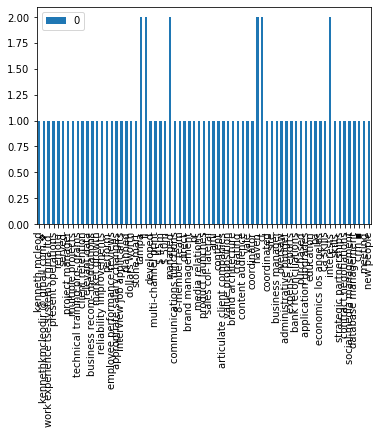

In [58]:
import pandas
from collections import Counter
letter_counts = Counter(phrases)
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')

In [59]:
from itertools import dropwhile

for key, count in dropwhile(lambda key_count: key_count[1] >= 2, letter_counts.most_common()):
    del letter_counts[key]

In [60]:
letter_counts

Counter({'tampa': 2,
         'fl': 2,
         'managed': 2,
         'haven': 2,
         'ct': 2,
         'interests': 2})